# Objective:
To implement the techniques learnt as a part of the course.

# Data Description:
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from
February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

## Import the libraries

In [167]:
# install and import necessary libraries.

!pip install beautifulsoup4

import re, string, unicodedata                          # Import Regex, string and unicodedata.
#import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rpatil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rpatil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rpatil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load dataset

In [168]:
# Loading data into pandas dataframe
data = pd.read_csv("Tweets.csv")

## Shape of data

In [169]:
data.shape                                               # print shape of data.

(14640, 15)

## Data description

In [170]:
data.head()                                              # Print first 5 rows of data.

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Drop all other columns except “text” and “airline_sentiment”.

In [172]:
# Taking only 50000 entries for demonstration purpose. As full data will take more time to process.
# Only keeping score and Text columns from the data, as these are useful for our analysis.

data = data.loc[:, ['text', 'airline_sentiment']]

## Print first 5 rows of data

In [173]:
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


In [174]:
data.isnull().sum(axis=0)                                # Check for NULL values.

text                 0
airline_sentiment    0
dtype: int64

In [175]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)

data.tail()                                 # Check first 5 rows of data

,text,airline_sentiment
14635,@AmericanAir thank you we got on a different flight to Chicago.,positive
14636,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,negative
14637,@AmericanAir Please bring American Airlines to #BlackBerry10,neutral
14638,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",negative
14639,@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?,neutral


## Shape of data.

In [176]:
data.shape                                # Shape of data

(14640, 2)

# Data Pre-processing:

- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.\
- Remove numbers.
- Tokenization
- To remove Stopwords.
- Lemmatized data

We have used NLTK library to tokenize words , remove stopwords and lemmatize the remaining words.

## a) Html tag removal.

In [177]:
# a. Html tag removal.

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(lambda x: strip_html(x))
data.tail()

,text,airline_sentiment
14635,@AmericanAir thank you we got on a different flight to Chicago.,positive
14636,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,negative
14637,@AmericanAir Please bring American Airlines to #BlackBerry10,neutral
14638,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",negative
14639,@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?,neutral


## b) Removal of Special Characters and Punctuations.

In [178]:
# b. Removal of Special Characters and Punctuations.

import re
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

data['text'] = data['text'].apply(lambda x: remove_special_characters(x))



## c) Remove the numbers.

In [179]:
#c. Remove the numbers.

def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data.head()

,text,airline_sentiment
0,VirginAmerica What dhepburn said,neutral
1,VirginAmerica plus youve added commercials to the experience tacky,positive
2,VirginAmerica I didnt today Must mean I need to take another trip,neutral
3,VirginAmerica its really aggressive to blast obnoxious entertainment in your guests faces they have little recourse,negative
4,VirginAmerica and its a really big bad thing about it,negative


## d) Tokenization.

In [180]:
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data

In [181]:
data

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",neutral
1,"[VirginAmerica, plus, youve, added, commercials, to, the, experience, tacky]",positive
2,"[VirginAmerica, I, didnt, today, Must, mean, I, need, to, take, another, trip]",neutral
3,"[VirginAmerica, its, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]",negative
4,"[VirginAmerica, and, its, a, really, big, bad, thing, about, it]",negative
...,...,...
14635,"[AmericanAir, thank, you, we, got, on, a, different, flight, to, Chicago]",positive
14636,"[AmericanAir, leaving, over, minutes, Late, Flight, No, warnings, or, communication, until, we, were, minutes, Late, Flight, Thats, called, shitty, customer, svc]",negative
14637,"[AmericanAir, Please, bring, American, Airlines, to, BlackBerry]",neutral
14638,"[AmericanAir, you, have, my, money, you, change, my, flight, and, dont, answer, your, phones, Any, other, suggestions, so, I, can, make, my, commitment]",negative


## e) Stopwords

In [182]:
sw = stopwords.words('english')
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [183]:
sw = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopswords = list(set(sw) - set(customlist)) 

## f) Lemmatize, Conversion to lowercase

In [184]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopswords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

data['text'] = data.apply(lambda row: normalize(row['text']), axis=1)
data.head()

,text,airline_sentiment
0,virginamerica dhepburn say,neutral
1,virginamerica plus youve add commercials experience tacky,positive
2,virginamerica didnt today must mean need take another trip,neutral
3,virginamerica really aggressive blast obnoxious entertainment guests face little recourse,negative
4,virginamerica really big bad thing,negative


# Vectorization

## a) Using CountVectorizer.

In [185]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()                # Keep only 1000 features as number of features will increase the processing time.
data_features = vectorizer.fit_transform(data['text'])

data_features = data_features.toarray()   

In [186]:
data_features.shape

(14640, 12664)

In [187]:
(data_features[0])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [188]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
label = le.fit_transform(data['airline_sentiment'])
                  

In [189]:
data

,text,airline_sentiment
0,virginamerica dhepburn say,neutral
1,virginamerica plus youve add commercials experience tacky,positive
2,virginamerica didnt today must mean need take another trip,neutral
3,virginamerica really aggressive blast obnoxious entertainment guests face little recourse,negative
4,virginamerica really big bad thing,negative
...,...,...
14635,americanair thank get different flight chicago,positive
14636,americanair leave minutes late flight warn communication minutes late flight thats call shitty customer svc,negative
14637,americanair please bring american airlines blackberry,neutral
14638,americanair money change flight dont answer phone suggestions make commitment,negative


In [190]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, label, test_size=0.3, random_state=42)

In [191]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

randomforest = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state = 22)

randomforest = randomforest.fit(X_train, y_train)

print(randomforest)

print(np.mean(cross_val_score(randomforest, data_features, label, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=22)
0.7201502732240437


In [192]:
result_cv = randomforest.predict(X_test)

### Confusion Matrix using count vectorizer.

<AxesSubplot:>

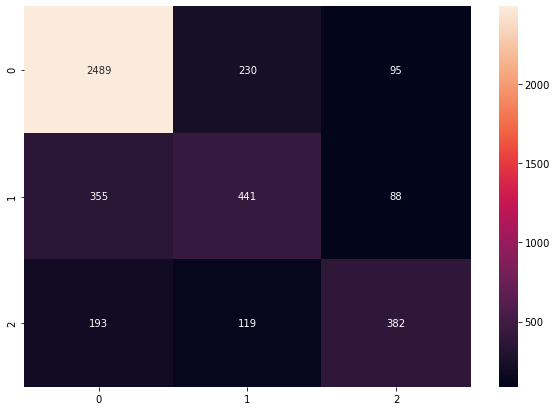

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

conf_mat = confusion_matrix(y_test, result_cv)

plt.figure(figsize = (10,7))
sns.heatmap(conf_mat, annot=True, fmt='g')

In [194]:
print("=====================Classification report for count vectorizer=========================")
print(classification_report(y_test, result_cv)) 

print("=====================Accuracy for count vectorizer=========================")
print(accuracy_score(y_test, result_cv))

=====================Classification report for count vectorizer=========================
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2814
           1       0.56      0.50      0.53       884
           2       0.68      0.55      0.61       694

    accuracy                           0.75      4392
   macro avg       0.68      0.64      0.66      4392
weighted avg       0.74      0.75      0.75      4392

=====================Accuracy for count vectorizer=========================
0.7540983606557377


## b) Using TfidfVectorizer.

In [195]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import TfidfVectorizer

TFidfvectorizer = TfidfVectorizer()                # Keep only 1000 features as number of features will increase the processing time.
Tfidf_data_features = TFidfvectorizer.fit_transform(data['text'])

Tfidf_data_features = Tfidf_data_features.toarray()   

In [196]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Tfidf_data_features, label, test_size=0.3, random_state=42)

In [197]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

randomforest = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state = 22)

randomforest = randomforest.fit(X_train, y_train)

print(randomforest)

print(np.mean(cross_val_score(randomforest, data_features, label, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=22)
0.7201502732240437


In [198]:
result_tv = randomforest.predict(X_test)

### Confusion Matrix using Tfidf vectorizer.

array([[2643,  140,   31],
       [ 465,  367,   52],
       [ 252,  102,  340]], dtype=int64)

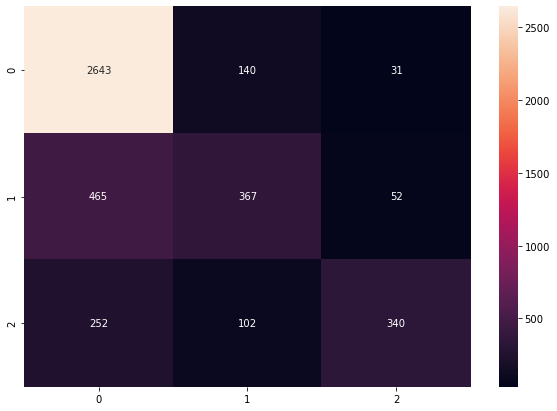

In [199]:
conf_mat = confusion_matrix(y_test, result_tv)

plt.figure(figsize = (10,7))
sns.heatmap(conf_mat, annot=True, fmt='g')
conf_mat

In [200]:
print("=====================Classification report for Tfidf vectorizer=========================")
print(classification_report(y_test, result_tv))

print("=====================Accuracy for Tfidf vectorizer=========================")
print(accuracy_score(y_test, result_tv))

=====================Classification report for Tfidf vectorizer=========================
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      2814
           1       0.60      0.42      0.49       884
           2       0.80      0.49      0.61       694

    accuracy                           0.76      4392
   macro avg       0.73      0.61      0.65      4392
weighted avg       0.75      0.76      0.74      4392

=====================Accuracy for Tfidf vectorizer=========================
0.7627504553734062


## Summarization:

1) Textual data is unstructured and cannot be processed as it is.

2) We clean up the text corpus to make it processable by ML

3) This text clean-up process is called text pre-processing.

4) Beautiful Soup: It can be used to scrape data from web and also for text cleaning with its in built parsers.

5) Often, unstructured text contains a lot of noise, especially if you use techniques like web or screen scraping. HTML tags are typically one of these components which don’t add much value towards understanding and analyzing text.

6) Special characters and symbols are usually non-alphanumeric characters or even occasionally numeric characters (depending on the problem), which add to the extra noise in unstructuredtext.

7) Tokenization is the task of taking a text or set of text and breaking it up into its individual tokens.

8) Stopwords are common words that carry less important meaning than keyword. When using some bag of words based methods, i.e, countVectorizer or tf-idfthat works on counts and frequency of the words, removing stopwords is great as it lowers the dimensionality.

9) Lemmatization involves resolving words to their dictionary form.

10) One of the advantage of TF-IDF over count is it reduce the impact of tokens that occur very frequently, hence offering little to none in terms of information.

## Performance of Model:

Random Forest Model using Tfidf vectorizer show better cross validation score then count vectorizer. For count vectorizer cross validation score is 72.01% and accuracy score 75.40% and for Tfidf vectorizer cross validation score is 72.01% and accuracy score if 76.27%.